## Modélisation de la régression logistique

In [66]:
# import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [67]:
# import du dataset
dataset = pd.read_csv('sba_national_clean.csv')

### Constitution du train/test

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
# suppression des variables non-nécessaires pour le modèle
dataset = dataset.drop(['LoanNr_ChkDgt','Name','City','Zip','Bank','ChgOffDate','DisbursementDate','DisbursementGross','BalanceGross','ChgOffPrinGr','SBA_Appv'],axis=1)

In [70]:
dataset.dtypes

State             object
BankState         object
NAICS              int64
ApprovalDate       int64
ApprovalFY         int64
Term               int64
NoEmp              int64
NewExist           int64
CreateJob          int64
RetainedJob        int64
FranchiseCode      int64
UrbanRural         int64
RevLineCr          int64
LowDoc             int64
MIS_Status         int64
GrAppv           float64
crysis_year       object
dtype: object

In [ ]:
# Création des variables X (features) et y (target)
X = dataset.drop("MIS_Status", axis=1)
y = dataset["MIS_Status"]

# Séparation du dataset en dataset d'entrainement et de test(test_size de 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Pipeline

In [72]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [73]:
# Identification des variables numériques et catégorielles pour le preproccessing
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [74]:

# Pipeline pour le preproccessing des variables numériques
numerical_pipeline = Pipeline([
    # Imputation des valeurs manquantes
    ('imputer', SimpleImputer(strategy='mean')),
    # Normalisation des données numériques
    ('scaler', StandardScaler())
])

# Pipeline pour le preproccessing des données catégorielles
categorical_pipeline = Pipeline([
    # Imputation des valeurs manquantes
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Encodage des variables catégorielles
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

# Combinaison des deux pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Création de la pipeline finale avec le preproccessing et modèle de régression logistique avec pondération des classes prédites
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

In [75]:
# Entraînement du modèle
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'GrAppv'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['State', 'BankState', 'crysis_year'], dtype='object'))])),
                ('classifier', LogisticRegression(class_weight='balanced'))])

### Evaluation du modèle de régression logistique

In [76]:
# Prédictions sur le jeu d'entrainement
y_train_pred = pipeline.predict(X_train)

# Prédictions sur le jeu de test
y_test_pred = pipeline.predict(X_test)

In [77]:
# Évaluation avec les métriques recall, precision et f1-score

# avec les données d'entrainement
print("Scores sur les données d'entrainement")
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print()

# avec les données de test
print("Scores sur les données de test")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Scores sur les données d'entrainement
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.82      0.53    126104
           1       0.95      0.73      0.82    591629

    accuracy                           0.74    717733
   macro avg       0.67      0.77      0.68    717733
weighted avg       0.85      0.74      0.77    717733


Scores sur les données de test
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.82      0.53     31454
           1       0.95      0.73      0.82    147980

    accuracy                           0.74    179434
   macro avg       0.67      0.77      0.67    179434
weighted avg       0.85      0.74      0.77    179434



In [78]:
from sklearn.metrics import roc_curve, auc

roc_auc = 0.7721183378051746


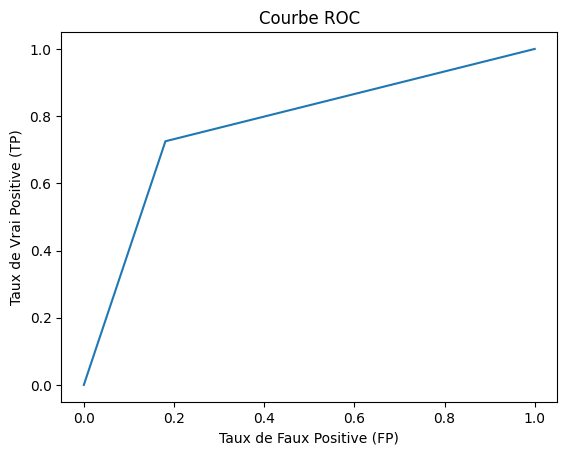

In [79]:
# visualisation de la courbe ROC pour les données de test
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr,tpr)

print(f"roc_auc = {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("Taux de Faux Positive (FP)")
plt.ylabel("Taux de Vrai Positive (TP)")
plt.title("Courbe ROC")
plt.show()

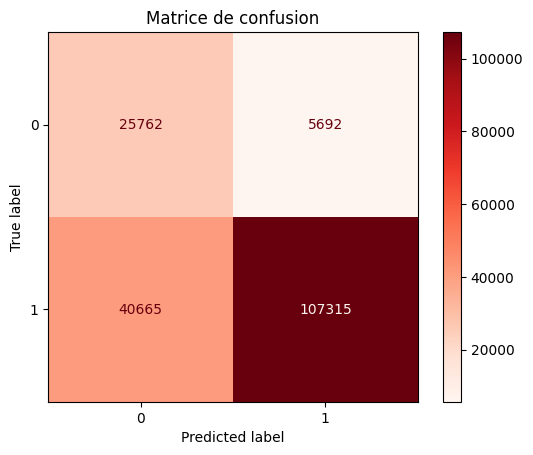

In [80]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Reds")
plt.title('Matrice de confusion')
plt.show()

## Implémentation du modèle XGBOOST

In [81]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [94]:
# Création de la pipeline finale avec le preproccessing et modèle de boosting
pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators = 400, max_depth=8, learning_rate=0.01, objective='binary:logistic'))  # Régression logistique
])

In [95]:
# Entrainement du modèle xgboost avec les données d'entrainement
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'GrAppv'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### Evaluation du modèle xgboost

In [96]:
# Prédictions sur le jeu d'entrainement
y_train_pred2 = pipeline_2.predict(X_train)

# Prédictions sur le jeu de test
y_test_pred2 = pipeline_2.predict(X_test)

In [97]:
# Évaluation avec les métriques recall, precision et f1-score

# avec les données d'entrainement
print("Scores sur les données d'entrainement")
print("Classification Report:\n", classification_report(y_train, y_train_pred2))
print()

# avec les données de test
print("Scores sur les données de test")
print("Classification Report:\n", classification_report(y_test, y_test_pred2))

Scores sur les données d'entrainement
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84    126104
           1       0.96      0.98      0.97    591629

    accuracy                           0.95    717733
   macro avg       0.92      0.89      0.91    717733
weighted avg       0.95      0.95      0.95    717733


Scores sur les données de test
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84     31454
           1       0.96      0.98      0.97    147980

    accuracy                           0.95    179434
   macro avg       0.92      0.89      0.90    179434
weighted avg       0.94      0.95      0.95    179434



roc_auc = 0.8905670092434801


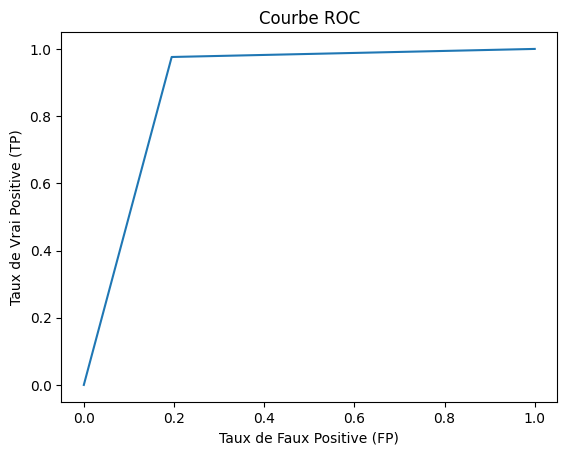

In [99]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred2)
roc_auc = auc(fpr,tpr)

print(f"roc_auc = {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("Taux de Faux Positive (FP)")
plt.ylabel("Taux de Vrai Positive (TP)")
plt.title("Courbe ROC")
plt.show()

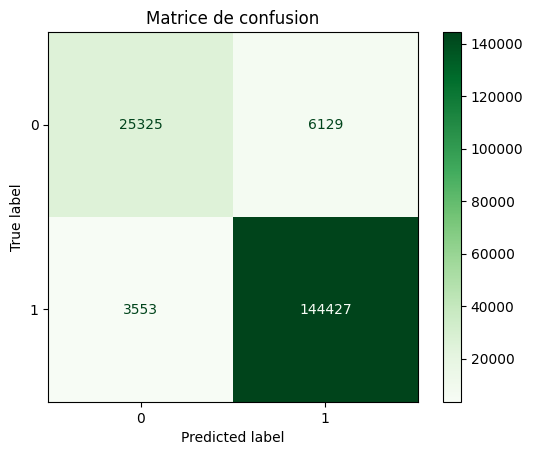

In [100]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
plt.title('Matrice de confusion')
plt.show()